In [1]:
!wget https://mimuw.edu.pl/~bilinski/VRNN2022/labs/B.%20BackProp/data.pkl

--2022-03-21 14:13:21--  https://mimuw.edu.pl/~bilinski/VRNN2022/labs/B.%20BackProp/data.pkl
Resolving mimuw.edu.pl (mimuw.edu.pl)... 193.0.96.14
Connecting to mimuw.edu.pl (mimuw.edu.pl)|193.0.96.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228311414 (218M)
Saving to: ‘data.pkl’

data.pkl            100%[===================>] 217.73M  6.57MB/s    in 34s     

2022-03-21 14:13:55 (6.42 MB/s) - ‘data.pkl’ saved [228311414/228311414]



In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('data.pkl', 'rb') as f:
  data = pickle.load(f)
training_data, test_data = np.array(data[0], dtype="object"), np.array(data[2], dtype="object")

In [3]:
np.random.seed( 1000 )

n_input, n_hidden, n_output = 784, 16, 10
biases = [ np.random.randn(n_hidden, 1), np.random.randn(n_output, 1) ]
weights = [ np.random.randn(n_hidden, n_input), np.random.randn(n_output, n_hidden) ]

n_epochs, lr = 20, 0.15

In [4]:
class MLP:
    def __init__(self, hidden_layer_shape):
        self.hidden_layer_shape = hidden_layer_shape
    
    def sigmoid(self, z, deriv = False):
        y = 1 / (1 + np.exp(-z))
        if deriv:
            return y * (1-y)
        return y

    def l2(self, y, y_pred, deriv = False):
        diff = y - y_pred
        if deriv:
            return -diff
        return 0.5*(diff)**2

    def cross_entropy(self, y, y_pred, deriv = False):
        if deriv:
            return (y-y_pred)/(y_pred*(1-y_pred))
        return -(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

    def output_cost(self, y, y_pred, z = None, quad = False, entropy = False):
        if quad:
            # pochodne z l2 po aktywacji neurona j z warstwy L, to całe, razy pochodna z sigmoid(z_L) gdzie L to warstwa output
            return (y_pred - y) * self.sigmoid(z)
        elif entropy:
            # pochodna z cross entropy, upraszcza się dzięki pochodnej z sigmoid
            return y_pred - y

    def forward_step(self, prev_x, curr_w, curr_b):
        z_l = np.matmul(curr_w, prev_x).reshape(-1, 1) + curr_b
        return self.sigmoid(z_l), z_l

    def forward(self, x):
        a_l = x # input neurons
        activations = []
        for l in range(len(self.hidden_layer_shape)+1): # hidden layers + output
            a_l, z_l = self.forward_step(a_l, self.weights[l], self.biases[l])
            activations.append(np.array([a_l, z_l]))
        return activations

    def backprop(self, x, y):
        nabla_b = [np.array([]) for l in range(len(self.hidden_layer_shape)+1)]
        nabla_w = [np.array([]) for l in range(len(self.hidden_layer_shape)+1)]
        # forward pass
        activations = self.forward(x)
        y_pred = activations[-1][0]
        output_z = activations[-1][1]
        # initial delta for output layer
        delta_l = self.output_cost(y, y_pred, output_z, entropy=True)
        # backward pass
        nabla_b[-1] = delta_l
        nabla_w[-1] = delta_l * activations[-2][0].T
        for l in range(-2, -len(self.weights)-1, -1): # excludint output layer
            delta_l = np.matmul(self.weights[l+1].T, delta_l) * self.sigmoid(activations[l][1], True)
            nabla_b[l] = delta_l
            if l > -len(self.weights):
                nabla_w[l] = delta_l * activations[l-1][0].T
            else: # input layer
                nabla_w[l] = delta_l * x.T
        return nabla_w, nabla_b

    def initialize(self, input_dim, output_dim):
        self.weights = [np.random.randn(self.hidden_layer_shape[0], input_dim)]
        self.biases = [np.zeros((self.hidden_layer_shape[0], 1))]
        for l in range(1, len(self.hidden_layer_shape)):
            self.weights.append(np.random.randn(self.hidden_layer_shape[l], self.hidden_layer_shape[l-1]))
            self.biases.append(np.zeros((self.weights[-1].shape[0], 1)))
        self.weights.append(np.random.randn(output_dim, self.weights[-1].shape[0]))
        self.biases.append(np.zeros((self.weights[-1].shape[0], 1)))

    def train(self, train_data, n_epochs=20, lr=0.1, batch_size=3, test_data=None):
        input_dim = len(train_data[0][0])
        output_dim = len(train_data[0][1])

        self.initialize(input_dim, output_dim)

        for ep in range(n_epochs):
            # train
            np.random.shuffle(train_data)
            for i in range(0, len(train_data), batch_size):
                start, end = i, i+batch_size
                minibatch = train_data[start:end]
                nablas_w = [np.zeros(weight.shape) for weight in self.weights]
                nablas_b = [np.zeros(bias.shape) for bias in self.biases]
                for x, y in minibatch:
                    nabla_wi, nabla_bi = self.backprop(x, y)
                    for l in range(len(self.hidden_layer_shape)+1):
                        nablas_w[l] += nabla_wi[l]
                        nablas_b[l] += nabla_bi[l]
                for l in range(len(self.hidden_layer_shape)+1):
                    self.weights[l] -= lr/len(minibatch) * nablas_w[l]
                    self.biases[l] -= lr/len(minibatch) * nablas_b[l]
            
            if test_data is not None:
                # evaluate
                s = 0
                for x, y in test_data:
                    output = self.forward(x)
                    s += int(np.argmax(output[-1][0]) == y)
                print("Epoch {} : {} / {}".format( ep, s, len(test_data) ))

    def predict(self, x, y = None):
        prediction = self.forward(x)[-1][0] # output activations
        if y is not None:
            plt.imshow(x.reshape(28, 28))
            plt.show()
            print("na obrazku jest:", int(np.argmax(prediction)))
            print("Dobrze" if int(np.argmax(prediction) == y) else "Źle")
        return prediction

mlp = MLP([25, 15])
mlp.train(training_data, 10, 0.1, 1, test_data)

Epoch 0 : 8674 / 10000
Epoch 1 : 9105 / 10000
Epoch 2 : 9222 / 10000
Epoch 3 : 9244 / 10000
Epoch 4 : 9240 / 10000
Epoch 5 : 9268 / 10000
Epoch 6 : 9353 / 10000
Epoch 7 : 9289 / 10000
Epoch 8 : 9397 / 10000
Epoch 9 : 9300 / 10000


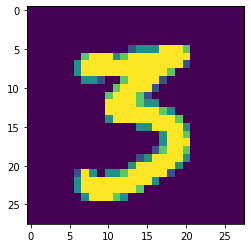

na obrazku jest: 3
Dobrze


In [14]:
x, y = test_data[np.random.randint(0, 10_000)]
y_hat = mlp.predict(x, y)

In [6]:
def sigmoid(z, deriv = False):
    y = 1 / (1 + np.exp(-z))
    if deriv:
      return y * (1-y)
    return y

def l1(y, y_pred, deriv = False):
    diff = y - y_pred
    if deriv:
        return -diff/abs(diff)
    return abs(diff)

def l2(y, y_pred, deriv = False):
    diff = y - y_pred
    if deriv:
        return -diff
    return 0.5*(diff)**2

def cost(y, y_pred, deriv = False, l1_reg = False):
    reg_func = l2
    if l1_reg:
        reg_func = l1
    return np.sum([reg_func(y[i], y_pred[i], deriv) for i in range(len(y))])

def forward_step(prev_x, curr_w, curr_b):
    z_l = np.matmul(curr_w, prev_x).reshape(-1, 1) + curr_b
    return sigmoid(z_l), z_l

def forward(x):
    a_l = x # input neurons
    hidden = np.array(weights, dtype="object")
    bias = np.array(biases, dtype="object")
    output = []
    for l in range(2): # two non-input layers
        a_l, z_l = forward_step(a_l, hidden[l], bias[l])
        output.append([a_l, z_l])
    return bias, hidden, np.array(output, dtype="object")

def backprop(x, y):
    nabla_b = [np.array([]) for l in range(2)]
    nabla_w = [np.array([]) for l in range(2)]
    # forward pass
    bias, hidden, activations = forward(x)
    y_pred = activations[-1, 0]
    output_z = activations[-1, 1]
    # initial delta for output layer
    # pochodne z l2 po aktywacji neurona j z warstwy L, to całe, razy pochodna z sigmoid(z_L) gdzie L to warstwa output
    delta_l = np.array([l2(y[j], y_pred[j], True) for j in range(len(y))]) * sigmoid(output_z, True)
    # backward pass
    nabla_b[-1] = delta_l
    nabla_w[-1] = delta_l * activations[-2][0].T
    for l in range(-2, -len(hidden)-1, -1): # one hidden layer
        delta_l = np.matmul(hidden[l+1].T, delta_l) * sigmoid(activations[l, 1], True)
        nabla_b[l] = delta_l
        if l > -2:
            nabla_w[l] = delta_l * activations[l-1][0].T
        else: # input layer
            nabla_w[l] = delta_l * x.T
    return nabla_w, nabla_b

In [7]:
#gradient descend
np.random.seed( 1000 )

n_input, n_hidden, n_output = 784, 16, 10
biases = [ np.random.randn(n_hidden, 1), np.random.randn(n_output, 1) ]
weights = [ np.random.randn(n_hidden, n_input), np.random.randn(n_output, n_hidden) ]

n_epochs, lr = 200, 5
for ep in range(n_epochs):
    # train
    nablas_w = [np.zeros(weights[l].shape) for l in range(2)]
    nablas_b = [np.zeros(biases[l].shape) for l in range(2)]
    for x, y in training_data:
        nabla_wi, nabla_bi = backprop(x, y)
        for l in range(2):
            nablas_w[l] += nabla_wi[l]
            nablas_b[l] += nabla_bi[l]
    for l in range(2):
        weights[l] -= lr/len(training_data) * nablas_w[l]
        biases[l] -= lr/len(training_data) * nablas_b[l]
    # evaluate
    s = 0
    for x, y in test_data:
        bias, weight, output = forward( x )
        s += int(np.argmax(output[-1][0]) == y)
    print("Epoch {} : {} / {}".format( ep, s, len(test_data) ))

Epoch 0 : 1258 / 10000
Epoch 1 : 1364 / 10000
Epoch 2 : 1527 / 10000


KeyboardInterrupt: ignored

In [ ]:
#stohastic gradient descend
np.random.seed( 1000 )

n_input, n_hidden, n_output = 784, 16, 10
biases = [ np.random.randn(n_hidden, 1), np.random.randn(n_output, 1) ]
weights = [ np.random.randn(n_hidden, n_input), np.random.randn(n_output, n_hidden) ]

n_epochs, lr = 10, 0.1

for ep in range(n_epochs):
    # train
    np.random.shuffle(training_data)
    for x, y in training_data:
        nabla_wi, nabla_bi = backprop(x, y)
        for l in range(2):
            weights[l] -= lr * nabla_wi[l]
            biases[l] -= lr * nabla_bi[l]
    
    # evaluate
    s = 0
    for x, y in test_data:
        bias, weight, output = forward( x )
        s += int(np.argmax(output[-1][0]) == y)
    print("Epoch {} : {} / {}".format( ep, s, len(test_data) ))

In [ ]:
#minibatch gradient descend
np.random.seed( 1000 )

n_input, n_hidden, n_output = 784, 16, 10
biases = [ np.random.randn(n_hidden, 1), np.random.randn(n_output, 1) ]
weights = [ np.random.randn(n_hidden, n_input), np.random.randn(n_output, n_hidden) ]

n_epochs, lr = 50, 0.1
minibatch_size = 3

for ep in range(n_epochs):
    # train
    np.random.shuffle(training_data)
    for i in range(0, len(training_data), minibatch_size):
        start, end = i, i+minibatch_size
        minibatch = training_data[start:end]
        nablas_w = [np.zeros(weights[l].shape) for l in range(2)]
        nablas_b = [np.zeros(biases[l].shape) for l in range(2)]
        for x, y in minibatch:
            nabla_wi, nabla_bi = backprop(x, y)
            for l in range(2):
                nablas_w[l] += nabla_wi[l]
                nablas_b[l] += nabla_bi[l]
        for l in range(2):
            weights[l] -= lr/len(minibatch) * nablas_w[l]
            biases[l] -= lr/len(minibatch) * nablas_b[l]
    # evaluate
    s = 0
    for x, y in test_data:
        bias, weight, output = forward( x )
        s += int(np.argmax(output[-1][0]) == y)
    print("Epoch {} : {} / {}".format( ep, s, len(test_data) ))

In [ ]:
x, y = test_data[np.random.randint(0, 10_000)]
plt.imshow(x.reshape(28, 28))
plt.show()
bias, weight, output = forward(x)

print("na obrazku jest:", int(np.argmax(output[-1][0])))

print("Dobrze" if int(np.argmax(output[-1][0]) == y) else "Źle")

In [ ]:
def cross_entropy(y, y_pred, deriv = False):
    if deriv:
        return (y-y_pred)/(y_pred*(1-y_pred))
    return -(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))


cross_entropy(1, 0.99, True)